# Motion Detection

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import time

import motion_detection as md

In [3]:
# # change working directory to the project root directory
# current_dir = os.getcwd()
# os.chdir(current_dir + '/../../')
# # this should be the project root directory
# os.getcwd()

## Load Video Metadata

In [3]:
root = '../../'

In [4]:
video_metadata_df = pd.read_csv(f'{root}data/raw/combined/target_dataset_video_metadata.csv')

In [5]:
video_metadata_df.head()

,filename,label,data_source,frame_count,fps,duration_sec,width,height
0,banana_ne_1.mp4,banana,ne,51,12.00000,4,240,176
1,banana_sb_2.mp4,banana,sb,71,29.97003,2,1920,1080
2,banana_uf_3.mp4,banana,uf,246,29.97003,8,1920,1080
3,banana_vl_4.mp4,banana,vl,168,29.97003,5,1920,1080
4,banana_vl_5.mp4,banana,vl,378,59.94006,6,1280,720


## Motion Detection Demo

### Choose a row from the video metadata dataframe

In [6]:
i = 0
row = video_metadata_df.iloc[i]
path = f"{root}data/raw/combined/videos/{row.filename}"
fps = row.fps

In [7]:
path, fps

('../../data/raw/combined/videos/banana_ne_1.mp4', 12.0)

### Measure Motion - Basic, Optical Flow, & Background Subtraction methods

In [9]:
# Measure basic motion
start_time = time.time()
mm_basic_raw = md.measure_motion_basic(path)
mm_basic_normalized = md.normalize_list_of_data(mm_basic_raw)
basic_time = time.time() - start_time
print(f"Basic motion detection took {basic_time:.2f} seconds")

# Measure optical flow
start_time = time.time() 
mm_optical_flow_raw = md.measure_motion_optical_flow(path)
mm_optical_flow_normalized = md.normalize_list_of_data(mm_optical_flow_raw)
optical_time = time.time() - start_time
print(f"Optical flow method took {optical_time:.2f} seconds")

# Measure background subtraction
start_time = time.time()
mm_background_subtraction_raw = md.measure_motion_background_subtraction(path)
mm_background_subtraction_normalized = md.normalize_list_of_data(mm_background_subtraction_raw)
background_time = time.time() - start_time
print(f"Background subtraction method took {background_time:.2f} seconds")

# Combine the three motion measurements with a weighted average (weights 0.3, 0.3, 0.4)
mm_combined_normalized = md.weighted_average_motion(
    [mm_basic_normalized, mm_optical_flow_normalized, mm_background_subtraction_normalized,],
    weights = [0.3, 0.3, 0.4],
    )

print(F"\nTotal processing time: {basic_time + optical_time + background_time:.2f} seconds")

Basic motion detection took 0.02 seconds
Optical flow method took 0.41 seconds
Background subtraction method took 0.07 seconds

Total processing time: 0.50 seconds


#### Take moving average for smoother results

In [10]:
mm_basic = md.moving_average(mm_basic_normalized, fps, window_duration=0.334)
mm_optical_flow = md.moving_average(mm_optical_flow_normalized, fps, window_duration=0.334)
mm_background_subtraction = md.moving_average(mm_background_subtraction_normalized, fps, window_duration=0.334)

# Combine the three motion measurements with a weighted average (weights 0.3, 0.3, 0.4)
mm_combined = md.moving_average(mm_combined_normalized, fps, window_duration=0.334)

window_duration: 0.334 seconds, at 12.0 fps = 4 frame window_size
window_duration: 0.334 seconds, at 12.0 fps = 4 frame window_size
window_duration: 0.334 seconds, at 12.0 fps = 4 frame window_size
window_duration: 0.334 seconds, at 12.0 fps = 4 frame window_size


## Motion Visualization

### Video example with the normalised motion measurements

In [11]:
md.play_video_with_motion_graph(
    path,
    [mm_basic_normalized, mm_optical_flow_normalized, mm_background_subtraction_normalized, mm_combined_normalized],
    graph_height = 400,
    figsize = (6, 2),
    dpi = 150,
    legend_labels = ['Basic', 'Optical Flow', 'Background Sub', 'Weighted Avg'],
    alpha = 1
)


Video ended. Press 'r' to replay or 'q' to quit.
CLOSING THE WINDOW BY CLICKING X WILL KEEP THE CELL RUNNING!


### Video example with the normalised motion measurements, with a moving average applied

In [178]:
md.play_video_with_motion_graph(
    path,
    [mm_basic, mm_optical_flow, mm_background_subtraction, mm_combined],
    graph_height = 400,
    figsize = (6, 2),
    dpi = 150,
    legend_labels = ['Basic', 'Optical Flow', 'Background Sub', 'Weighted Avg'],
    alpha = 1
)

Video ended. Press 'r' to replay or 'q' to quit.
            CLOSING THE WINDOW BY CLICKING X WILL KEEP THE CELL RUNNING!


### Frame Analysis

#### Individual Frame

In [179]:
frame_number = 10
frame = md.get_frame(path, frame_number)

(-0.5, 1279.5, 1119.5, -0.5)

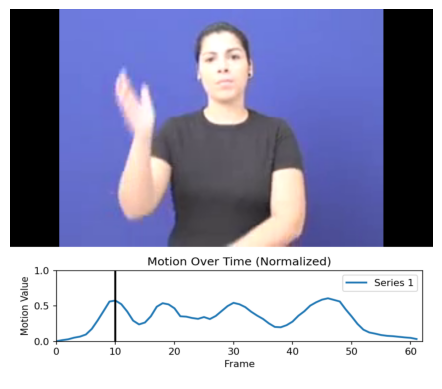

In [180]:
plot = md.create_frame_with_motion_graph(
    frame,
    [mm_combined],
    frame_number,
    target_width = 1280,
    target_height = 720,
    graph_height = 400,
    figsize = (6, 2),
    dpi = 150
)
plt.imshow(plot[:,:,::-1])
plt.axis('off')

### Multiple Frames

In [181]:
frame_numbers = [10, 14, 20, 30,  51]

#### Multiple Frames - One Motion Measurement Plot

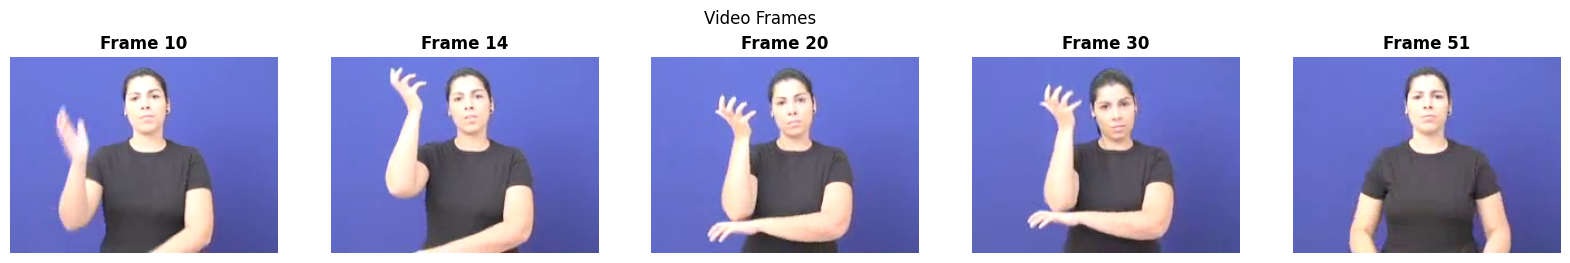

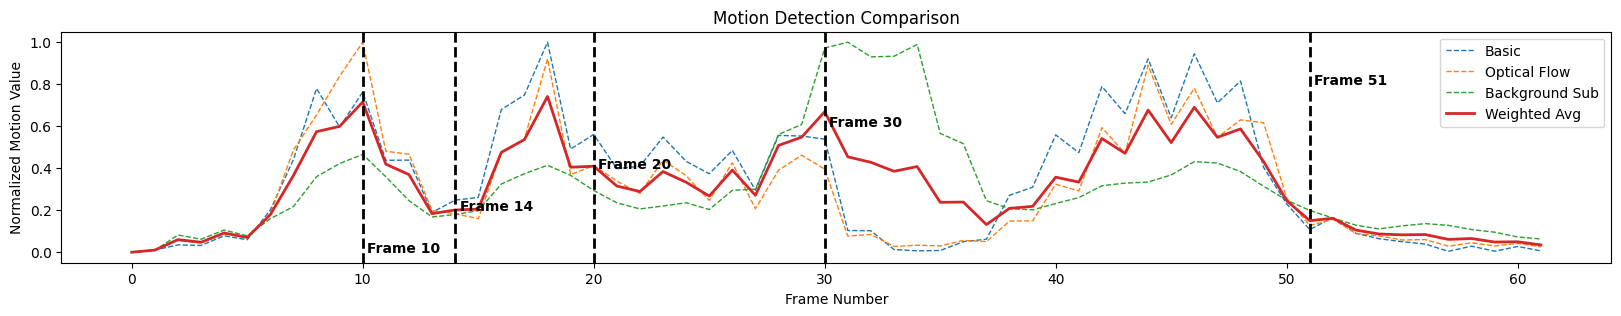

In [182]:
md.show_multiple_frames_one_plot(path, frame_numbers, [mm_basic_normalized, mm_optical_flow_normalized, mm_background_subtraction_normalized, mm_combined_normalized])

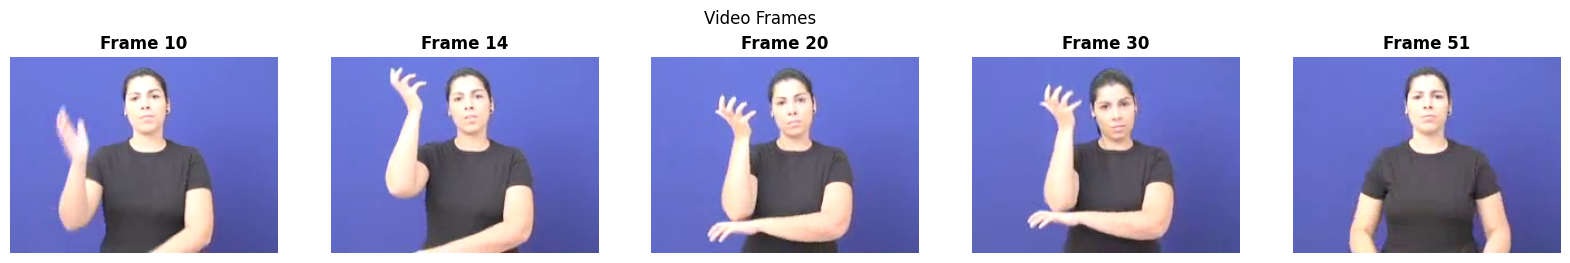

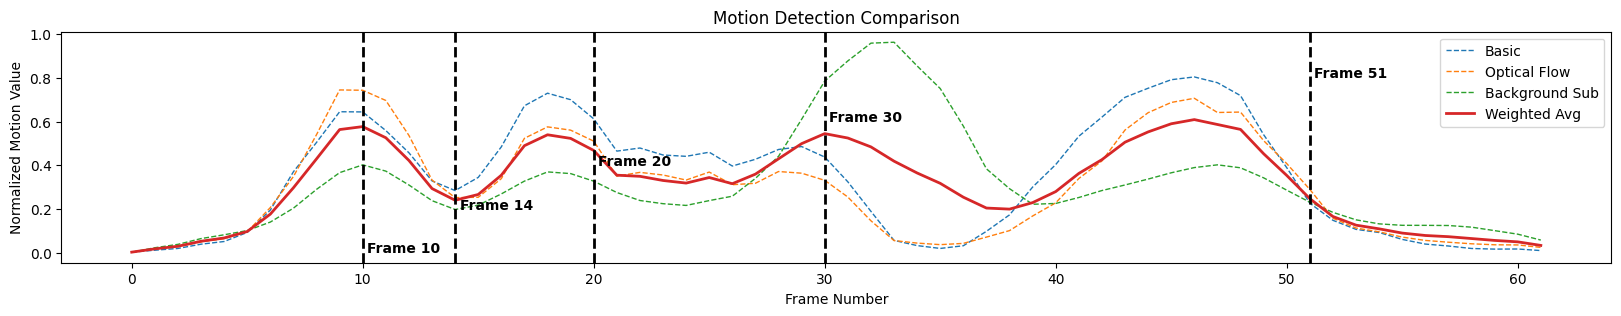

In [183]:
md.show_multiple_frames_one_plot(path, frame_numbers, [mm_basic, mm_optical_flow, mm_background_subtraction, mm_combined])

#### Multiple Frames - Multiple Motion Measurement Plots

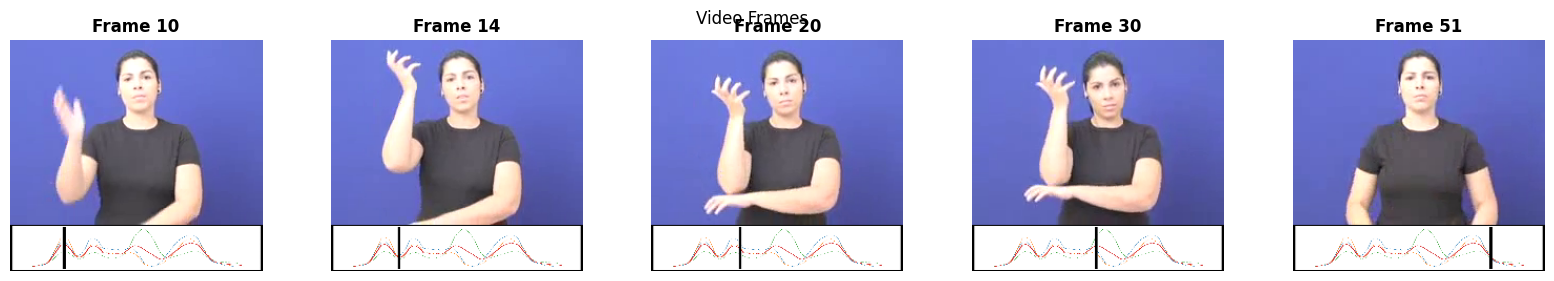

In [184]:
md.show_multiple_frames_multiple_plots(path, frame_numbers, [mm_basic, mm_optical_flow, mm_background_subtraction, mm_combined])

## Motion Analysis

### Simple Method - find the first and last frame above a set threshold value

#### INES

In [232]:
i = 0
row = video_metadata_df.iloc[i]
path = f"{root}data/raw/combined/videos/{row.filename}"
fps = row.fps
path, fps

('../../data/raw/combined/videos/ABACAXI_ne_1.mp4', 12.0)

In [233]:
weights = [0.5, 0.5]
window_duration = 0.334 #in seconds

In [234]:
# Measure basic motion
start_time = time.time()
mm_basic = md.moving_average(md.normalize_list_of_data(md.measure_motion_basic(path)), fps, window_duration=window_duration)
basic_time = time.time() - start_time
print(f"Basic motion detection took {basic_time:.2f} seconds")

# Measure background subtraction
start_time = time.time()
mm_bg_sub = md.moving_average(md.normalize_list_of_data(md.measure_motion_background_subtraction(path)), fps, window_duration=window_duration)
background_time = time.time() - start_time
print(f"Background subtraction method took {background_time:.2f} seconds")

# Combine with a weighted average
mm_combined = md.weighted_average_motion(
    [mm_basic, mm_bg_sub,],
    weights = [0.5, 0.5],
    )

print(F"\nTotal processing time: {basic_time + background_time:.2f} seconds")

window_duration: 0.334 seconds, at 12.0 fps = 4 frame window_size
Basic motion detection took 0.02 seconds
window_duration: 0.334 seconds, at 12.0 fps = 4 frame window_size
Background subtraction method took 0.10 seconds

Total processing time: 0.11 seconds


In [235]:
start_frame, end_frame = md.find_motion_boundaries_simple(
    mm_combined,
    start_threshold=0.2,
    end_threshold=0.2
)
start_frame, end_frame

(7, 51)

In [236]:
frame_numbers = [start_frame-1, start_frame, start_frame+1, start_frame+2, end_frame-2, end_frame-1, end_frame, end_frame+1]

# print the value in mm_combined for all the frames in frame_numbers, in one line
print([f" frame {frame_numbers[i]}: {round(mm_combined[frame_numbers[i]], 3)}" for i in range(len(frame_numbers))])

[' frame 6: 0.168', ' frame 7: 0.287', ' frame 8: 0.397', ' frame 9: 0.506', ' frame 49: 0.441', ' frame 50: 0.338', ' frame 51: 0.229', ' frame 52: 0.166']


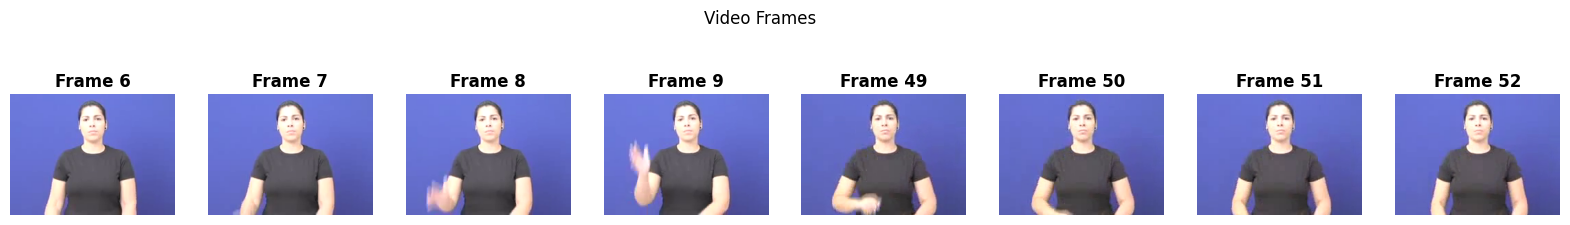

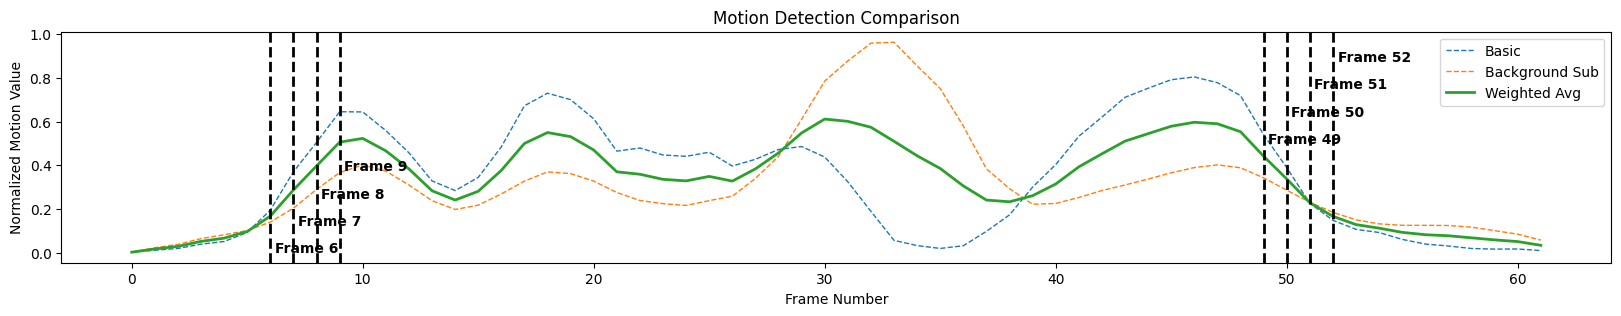

In [237]:
md.show_multiple_frames_one_plot(path, frame_numbers, [mm_basic, mm_bg_sub, mm_combined])

#### SignBank

In [238]:
i = 1
row = video_metadata_df.iloc[i]
path = f"{root}data/raw/combined/videos/{row.filename}"
fps = row.fps
path, fps

('../../data/raw/combined/videos/ABACAXI_sb_2.mp4', 29.97002997002997)

In [239]:
weights = [0.5, 0.5]
window_duration = 0.334 #in seconds

In [240]:
# Measure basic motion
start_time = time.time()
mm_basic = md.moving_average(md.normalize_list_of_data(md.measure_motion_basic(path)), fps, window_duration=window_duration)
basic_time = time.time() - start_time
print(f"Basic motion detection took {basic_time:.2f} seconds")

# Measure background subtraction
start_time = time.time()
mm_bg_sub = md.moving_average(md.normalize_list_of_data(md.measure_motion_background_subtraction(path)), fps, window_duration=window_duration)
background_time = time.time() - start_time
print(f"Background subtraction method took {background_time:.2f} seconds")

# Combine with a weighted average
mm_combined = md.weighted_average_motion(
    [mm_basic, mm_bg_sub,],
    weights = [0.5, 0.5],
    )

print(F"\nTotal processing time: {basic_time + background_time:.2f} seconds")

window_duration: 0.334 seconds, at 29.97002997002997 fps = 10 frame window_size
Basic motion detection took 0.32 seconds
window_duration: 0.334 seconds, at 29.97002997002997 fps = 10 frame window_size
Background subtraction method took 0.39 seconds

Total processing time: 0.71 seconds


In [241]:
start_frame, end_frame = md.find_motion_boundaries_simple(
    mm_combined,
    start_threshold=0.2,
    end_threshold=0.2
)
start_frame, end_frame

(4, 80)

In [242]:
frame_numbers = [start_frame - 2 , start_frame, start_frame+3, start_frame+6, end_frame-6, end_frame-3, end_frame, end_frame+2]

# print the value in mm_combined for all the frames in frame_numbers, in one line
print([f" frame {frame_numbers[i]}: {round(mm_combined[frame_numbers[i]], 3)}" for i in range(len(frame_numbers))])

[' frame 2: 0.114', ' frame 4: 0.218', ' frame 7: 0.46', ' frame 10: 0.644', ' frame 74: 0.629', ' frame 77: 0.432', ' frame 80: 0.238', ' frame 82: 0.145']


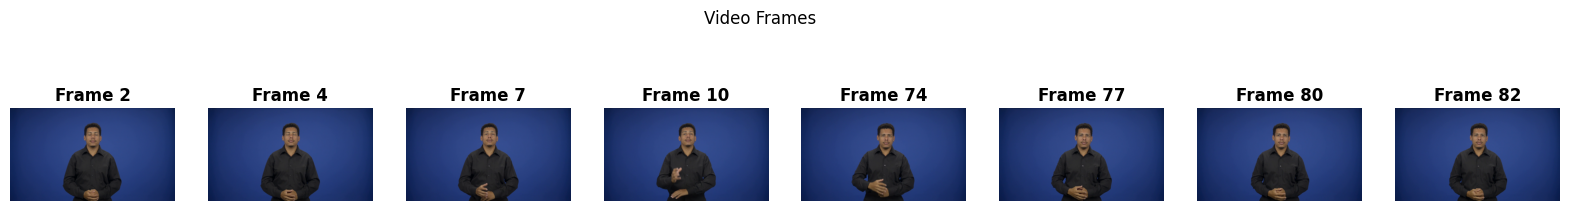

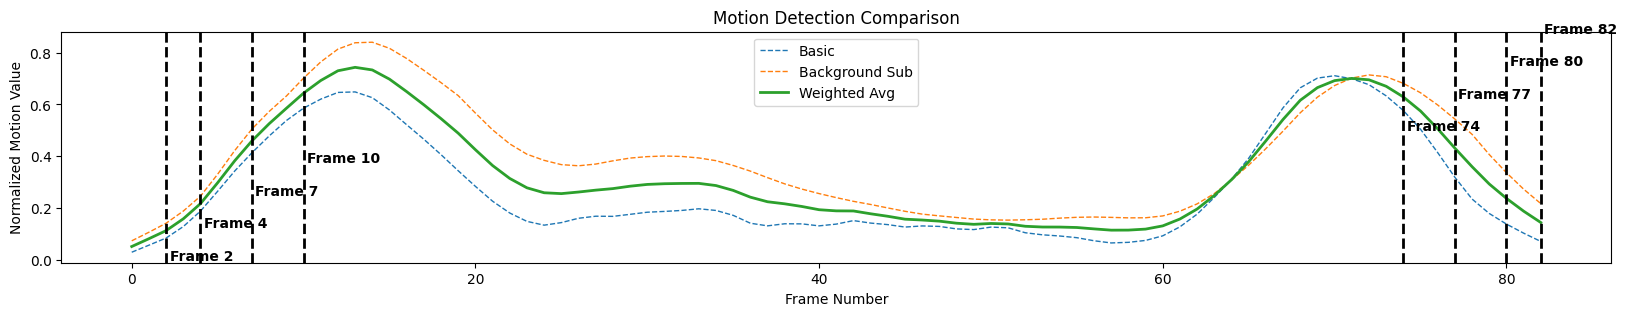

In [243]:
md.show_multiple_frames_one_plot(path, frame_numbers, [mm_basic, mm_bg_sub, mm_combined])

#### V-Librasil

In [214]:
i = 2
row = video_metadata_df.iloc[i]
path = f"{root}data/raw/combined/videos/{row.filename}"
fps = row.fps
path, fps

('../../data/raw/combined/videos/ABACAXI_vl_3.mp4', 29.97002997002997)

In [215]:
weights = [0.5, 0.5]
window_duration = 0.334 #in seconds

In [216]:
# Measure basic motion
start_time = time.time()
mm_basic = md.moving_average(md.normalize_list_of_data(md.measure_motion_basic(path)), fps, window_duration=window_duration)
basic_time = time.time() - start_time
print(f"Basic motion detection took {basic_time:.2f} seconds")

# Measure background subtraction
start_time = time.time()
mm_bg_sub = md.moving_average(md.normalize_list_of_data(md.measure_motion_background_subtraction(path)), fps, window_duration=window_duration)
background_time = time.time() - start_time
print(f"Background subtraction method took {background_time:.2f} seconds")

# Combine with a weighted average
mm_combined = md.weighted_average_motion(
    [mm_basic, mm_bg_sub,],
    weights = [0.5, 0.5],
    )

print(F"\nTotal processing time: {basic_time + background_time:.2f} seconds")

window_duration: 0.334 seconds, at 29.97002997002997 fps = 10 frame window_size
Basic motion detection took 1.10 seconds
window_duration: 0.334 seconds, at 29.97002997002997 fps = 10 frame window_size
Background subtraction method took 4.49 seconds

Total processing time: 5.58 seconds


In [220]:
start_frame, end_frame = md.find_motion_boundaries_simple(
    mm_combined,
    start_threshold=0.3,
    end_threshold=0.3,
)
start_frame, end_frame

(17, 153)

In [221]:
frame_numbers = [start_frame - 2 , start_frame, start_frame+3, start_frame+6, end_frame-6, end_frame-3, end_frame, end_frame+2]

# print the value in mm_combined for all the frames in frame_numbers, in one line
print([f" frame {frame_numbers[i]}: {round(mm_combined[frame_numbers[i]], 3)}" for i in range(len(frame_numbers))])

[' frame 15: 0.245', ' frame 17: 0.343', ' frame 20: 0.522', ' frame 23: 0.658', ' frame 147: 0.348', ' frame 150: 0.324', ' frame 153: 0.303', ' frame 155: 0.286']


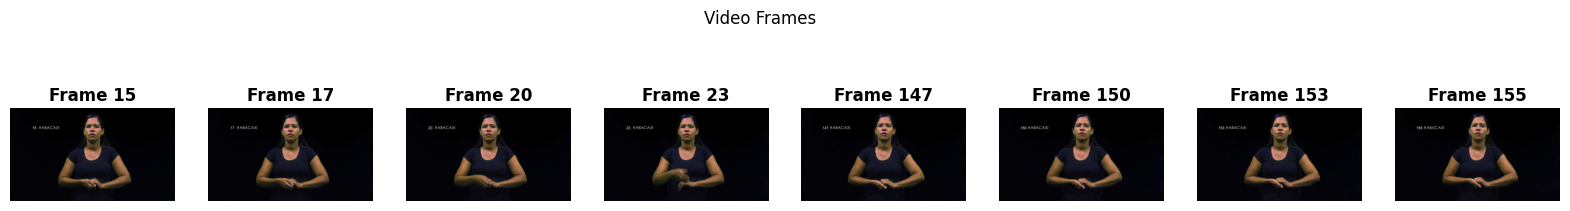

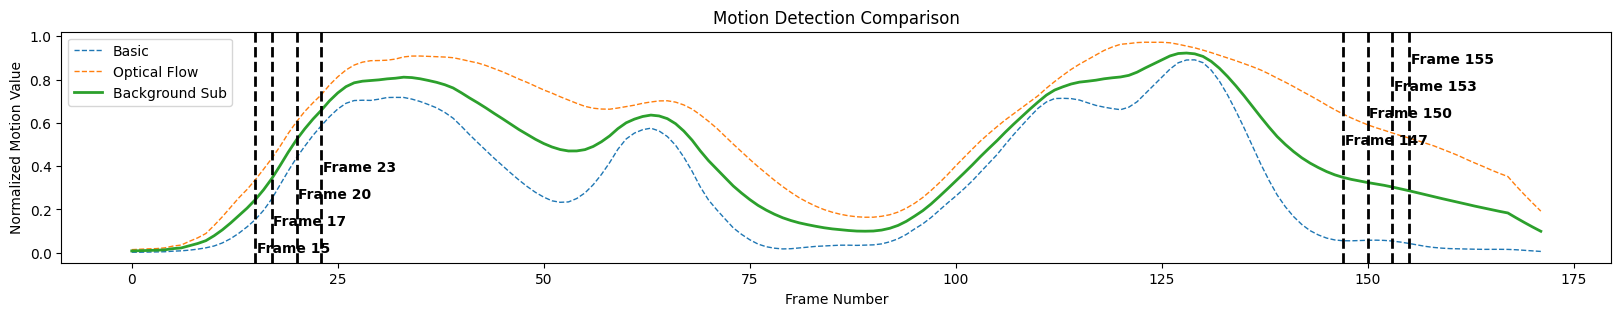

In [222]:
md.show_multiple_frames_one_plot(path, frame_numbers, [mm_basic, mm_bg_sub, mm_combined])

#### UFV

In [244]:
i = 5
row = video_metadata_df.iloc[i]
path = f"{root}data/raw/combined/videos/{row.filename}"
fps = row.fps
path, fps

('../../data/raw/combined/videos/ABACAXI_uf_6.mp4', 29.97002997002997)

In [245]:
weights = [0.5, 0.5]
window_duration = 0.334 #in seconds

In [246]:
# Measure basic motion
start_time = time.time()
mm_basic = md.moving_average(md.normalize_list_of_data(md.measure_motion_basic(path)), fps, window_duration=window_duration)
basic_time = time.time() - start_time
print(f"Basic motion detection took {basic_time:.2f} seconds")

# Measure background subtraction
start_time = time.time()
mm_bg_sub = md.moving_average(md.normalize_list_of_data(md.measure_motion_background_subtraction(path)), fps, window_duration=window_duration)
background_time = time.time() - start_time
print(f"Background subtraction method took {background_time:.2f} seconds")

# Combine with a weighted average
mm_combined = md.weighted_average_motion(
    [mm_basic, mm_bg_sub,],
    weights = [0.5, 0.5],
    )

print(F"\nTotal processing time: {basic_time + background_time:.2f} seconds")

window_duration: 0.334 seconds, at 29.97002997002997 fps = 10 frame window_size
Basic motion detection took 0.91 seconds
window_duration: 0.334 seconds, at 29.97002997002997 fps = 10 frame window_size
Background subtraction method took 4.34 seconds

Total processing time: 5.26 seconds


In [247]:
start_frame, end_frame = md.find_motion_boundaries_simple(
    mm_combined,
    start_threshold=0.3,
    end_threshold=0.3,
)
start_frame, end_frame

(12, 153)

In [248]:
frame_numbers = [start_frame - 2 , start_frame, start_frame+3, start_frame+6, end_frame-6, end_frame-3, end_frame, end_frame+2]

# print the value in mm_combined for all the frames in frame_numbers, in one line
print([f" frame {frame_numbers[i]}: {round(mm_combined[frame_numbers[i]], 3)}" for i in range(len(frame_numbers))])

[' frame 10: 0.248', ' frame 12: 0.315', ' frame 15: 0.366', ' frame 18: 0.401', ' frame 147: 0.422', ' frame 150: 0.359', ' frame 153: 0.303', ' frame 155: 0.27']


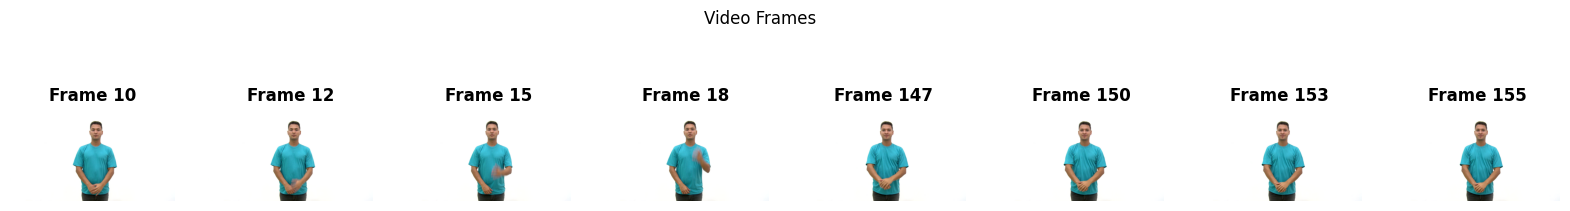

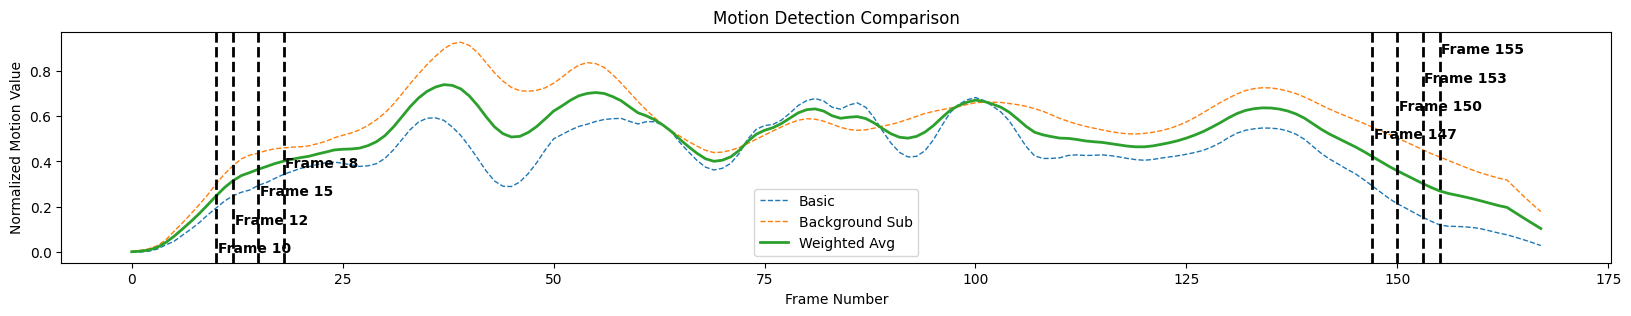

In [249]:
md.show_multiple_frames_one_plot(path, frame_numbers, [mm_basic, mm_bg_sub, mm_combined])

### Complex - Considers the duration of the motion, and the % increase/decrease in motion
- Sensitive to the parameters, which are tricky to tune
- Just skip and use the simple method for now

In [ ]:
start_frame, end_frame = md.find_motion_boundaries_complex(
    mm_combined,
    fps=fps,
    threshold=0.015,
    min_motion_duration=0.01
)
[start_frame, end_frame]

[0, 60]

In [ ]:
start_threshold = 0.3
end_threshold = 0.3
mm_array = np.array(mm_combined)
# first frame that exceeds start_threshold
start_frame = np.where(mm_array > start_threshold)[0][0]
# last frame that exceeds end_threshold
end_frame = np.where(mm_array > end_threshold)[0][-1]


In [ ]:
frame_numbers = [start_frame, start_frame+1, start_frame+2, start_frame+3, end_frame-3, end_frame-2, end_frame-1, end_frame]

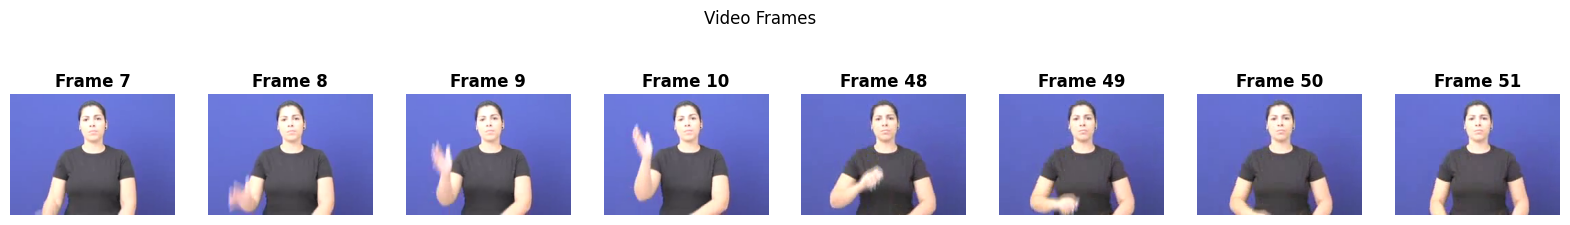

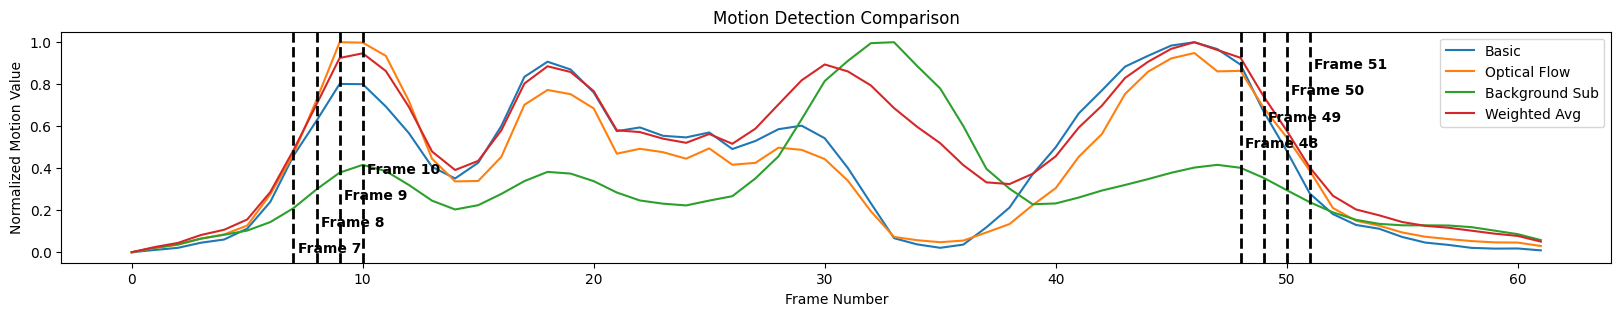

In [ ]:
md.show_multiple_frames_one_plot(path, frame_numbers, [mm_basic, mm_optical_flow, mm_background_subtraction, mm_combined])

In [ ]:
frame_numbers = [start_frame, start_frame+4, start_frame+8, end_frame-8, end_frame-4, end_frame]

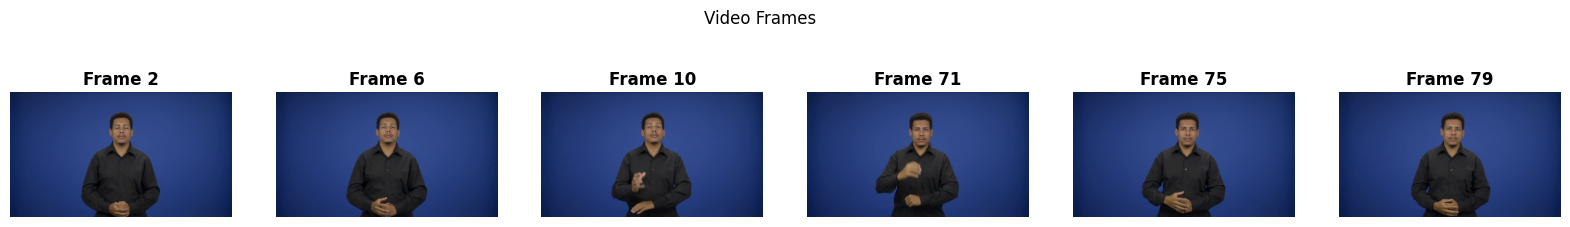

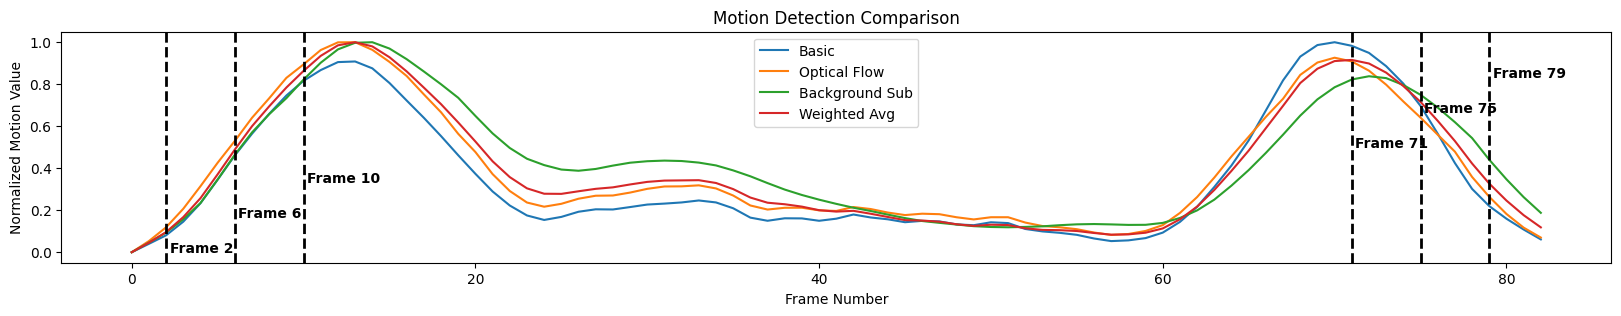

In [ ]:
md.show_multiple_frames_one_plot(path, frame_numbers, [mm_basic, mm_optical_flow, mm_background_subtraction, mm_combined])